In [1]:
import os
from copy import deepcopy
from PIL import Image
import torch
import torchvision.transforms as transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

e:\ML_Algorithm\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Configuration
train_dir = r"E:\ML_Algorithm\dataset\train"  # Replace with actual path
test_dir = r"E:\ML_Algorithm\dataset\test"

In [4]:
batch_size = 32
num_epochs = 10
patience = 3

In [5]:
# Feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

e:\ML_Algorithm\myenv\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [6]:
# Class info
num_classes = len(train_dataset.classes)
subtype_to_category = {}
for subtype in train_dataset.classes:
    if subtype.startswith("b"):
        subtype_to_category[subtype] = "benign"
    elif subtype.startswith("m"):
        subtype_to_category[subtype] = "malignant"
    else:
        subtype_to_category[subtype] = "unknown"

print(num_classes)

8


In [7]:
# Model and optimizer
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=num_classes
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float("inf")
counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model.state_dict())
        counter = 0

        os.makedirs("multiclass_models", exist_ok=True)
        torch.save(model.state_dict(), 'multiclass_models/best_model.pt')

        model_info = {
            'class_to_idx': train_dataset.class_to_idx,
            'feature_extractor_name': "google/vit-base-patch16-224-in21k",
            'classes': train_dataset.classes,
            'subtype_to_category': subtype_to_category
        }
        torch.save(model_info, 'multiclass_models/model_info.pt')

        print(f"Model saved at epoch {epoch+1} with val loss {val_loss:.4f}")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model for inference
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=num_classes
)
model.load_state_dict(torch.load('multiclass_models/best_model.pt'))
model.to(device)
print("Best model loaded.")




Epoch 1/10 - Train Loss: 1.0323, Train Acc: 0.6678, Val Loss: 0.7164, Val Acc: 0.7778
Model saved at epoch 1 with val loss 0.7164
Epoch 2/10 - Train Loss: 0.4038, Train Acc: 0.8697, Val Loss: 0.3244, Val Acc: 0.8880
Model saved at epoch 2 with val loss 0.3244
Epoch 3/10 - Train Loss: 0.2206, Train Acc: 0.9302, Val Loss: 0.3094, Val Acc: 0.8851
Model saved at epoch 3 with val loss 0.3094
Epoch 4/10 - Train Loss: 0.1205, Train Acc: 0.9622, Val Loss: 0.2150, Val Acc: 0.9234
Model saved at epoch 4 with val loss 0.2150
Epoch 5/10 - Train Loss: 0.0972, Train Acc: 0.9649, Val Loss: 0.2831, Val Acc: 0.9045
Epoch 6/10 - Train Loss: 0.0905, Train Acc: 0.9680, Val Loss: 0.3883, Val Acc: 0.8889
Epoch 7/10 - Train Loss: 0.0940, Train Acc: 0.9669, Val Loss: 0.2656, Val Acc: 0.9226
Early stopping triggered.


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rjhim\AppData\Local\Temp\ipykernel_15892\3691711496.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `t

Best model loaded.


In [9]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np

In [10]:
# Put model in evaluation mode
model.eval()

# Store all predictions and labels
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)


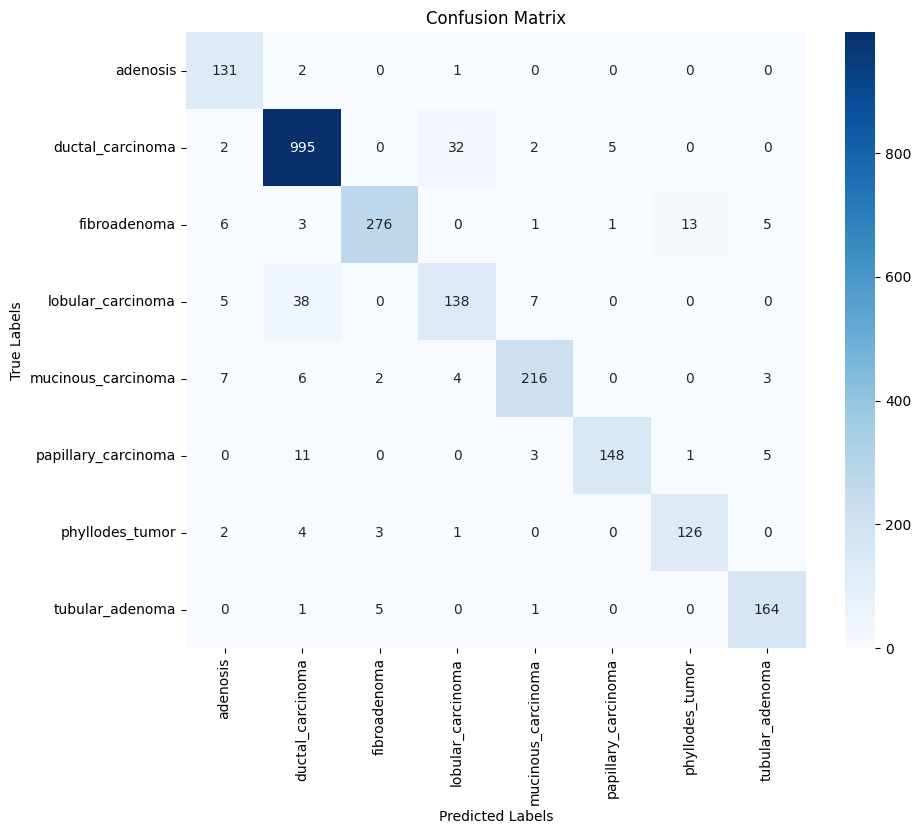

In [11]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


Multi-class ROC AUC Score: 0.9958


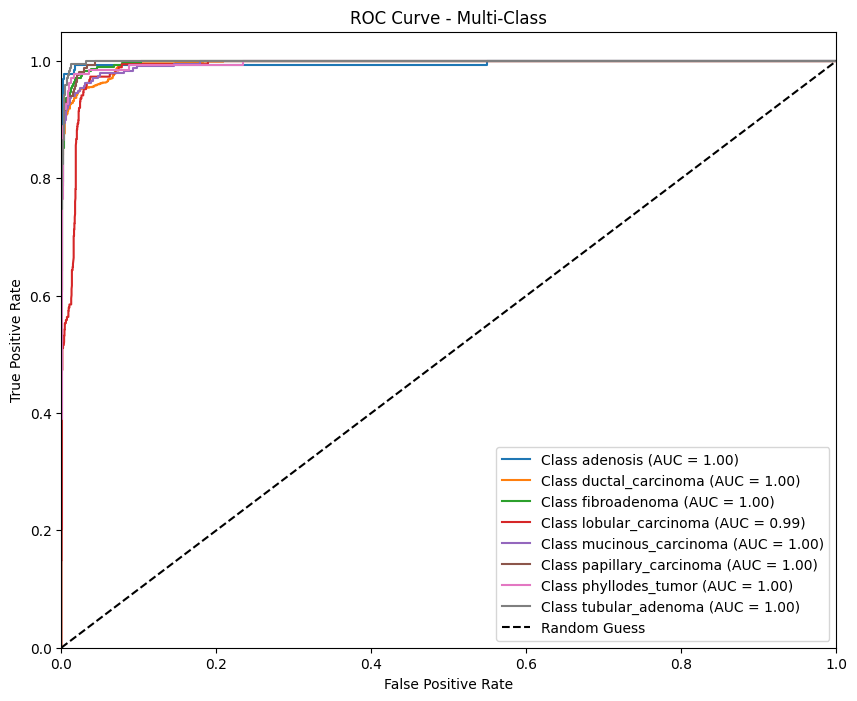

In [12]:
# Binarize labels for multiclass ROC
all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))

# Compute AUC score
roc_auc = roc_auc_score(all_labels_bin, all_probs, multi_class='ovr')
print(f"Multi-class ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc_per_class = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc_per_class[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {train_dataset.classes[i]} (AUC = {roc_auc_per_class[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class")
plt.legend(loc="lower right")
plt.show()


In [13]:
plt.savefig("confusion_matrix.png")
# or
plt.savefig("roc_curve.png")


<Figure size 640x480 with 0 Axes>

In [14]:
# Inference function
def predict_single_image(image_path, model_path='multiclass_models/best_model.pt', info_path='multiclass_models/model_info.pt'):
    from PIL import Image
    import torch

    model_info = torch.load(info_path)
    class_to_idx = model_info['class_to_idx']
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    subtype_to_category = model_info.get('subtype_to_category', {})

    feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
    model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224-in21k",
        num_labels=len(class_to_idx)
    )
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor).logits
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)

    subtype = idx_to_class[predicted_class.item()]
    category = subtype_to_category.get(subtype, "unknown")


    return subtype, category, confidence.item()

# Example usage
if __name__ == "__main__":
    image_path = r"E:\ML_Algorithm\dataset\test\fibroadenoma\SOB_B_F-14-9133-40-020.png"

    try:
        subtype, category, confidence = predict_single_image(image_path)
        category_dict = {"adenosis": "Benign", "fibroadenoma": "Benign", "phyllodes_tumor": "Benign",
                         "tubular_adenoma": "Benign", "ductal_carcinoma": "Malignant", "lobular_carcinoma": "Malignant",
                         "papillary_carcinoma": "Malignant", "mucous_carcinoma": "Malignant"}
        print(f"Prediction: {category_dict[subtype]} (Category: {subtype}), Confidence: {confidence:.4f}")
    except Exception as e:
        print(f"Error making prediction: {e}")

C:\Users\rjhim\AppData\Local\Temp\ipykernel_15892\884013258.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_info = torch.load(info_path)
e:\ML_Algorithm\myenv\Lib\

Prediction: Benign (Category: fibroadenoma), Confidence: 0.9783


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Set number of classes and class names
num_classes = len(class_to_idx)
class_names = [idx_to_class[i] for i in range(num_classes)]  # <-- from model_info

# Binarize labels for multiclass ROC
all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))

# Compute overall multi-class AUC
roc_auc_macro = roc_auc_score(all_labels_bin, all_probs, multi_class='ovr')
print(f"Overall Multi-class ROC AUC (macro-average): {roc_auc_macro:.4f}")

# Compute per-class ROC and AUC
fpr = dict()
tpr = dict()
roc_auc_per_class = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc_per_class[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap('tab10', num_classes)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i],
             label=f"{class_names[i]} (AUC = {roc_auc_per_class[i]:.2f})",
             color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'class_to_idx' is not defined

Overall Multi-class ROC AUC (macro-average): 0.9958


C:\Users\rjhim\AppData\Local\Temp\ipykernel_15892\3449651615.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_info = torch.load("multiclass_models/model_info.pt")
C

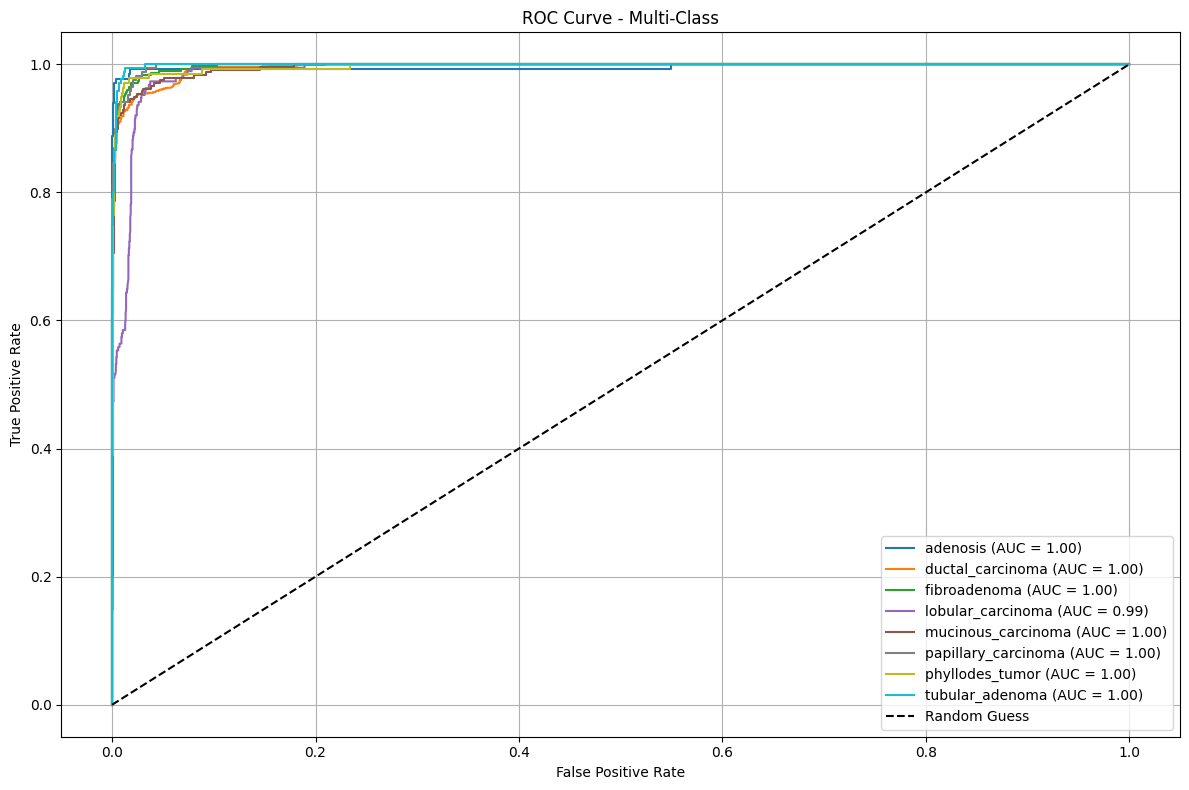

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import torch

# Load class mapping
model_info = torch.load("multiclass_models/model_info.pt")
class_to_idx = model_info["class_to_idx"]
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Get class details
num_classes = len(class_to_idx)
class_names = [idx_to_class[i] for i in range(num_classes)]

# Binarize labels for ROC
all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))

# Compute macro ROC AUC
roc_auc_macro = roc_auc_score(all_labels_bin, all_probs, multi_class='ovr')
print(f"Overall Multi-class ROC AUC (macro-average): {roc_auc_macro:.4f}")

# Per-class ROC and AUC
fpr = dict()
tpr = dict()
roc_auc_per_class = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc_per_class[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap('tab10', num_classes)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i],
             label=f"{class_names[i]} (AUC = {roc_auc_per_class[i]:.2f})",
             color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\rjhim\AppData\Local\Temp\ipykernel_15892\2993130211.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


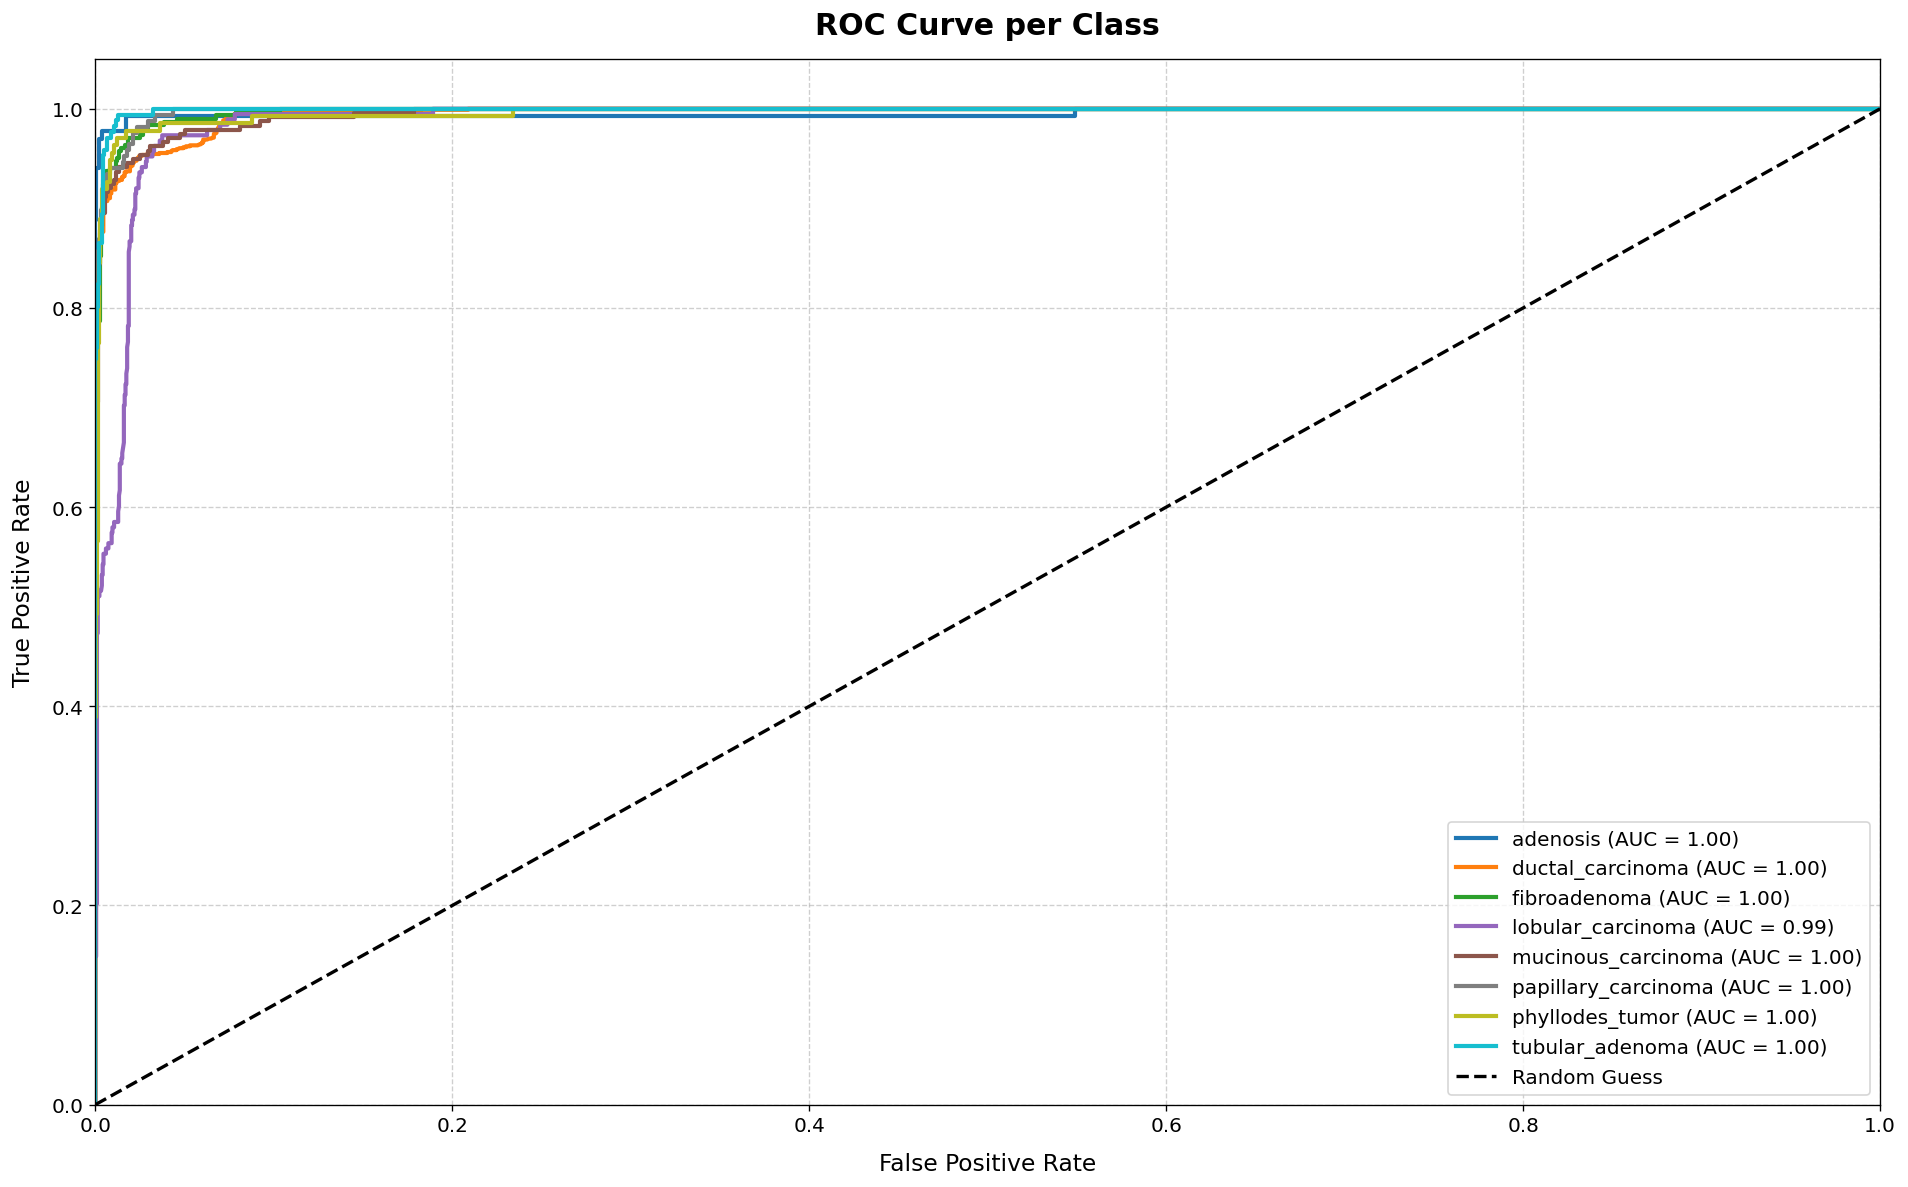

In [18]:
plt.figure(figsize=(16, 10), dpi=120)  # Larger figure and higher resolution
colors = plt.cm.get_cmap('tab10', num_classes)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i],
             label=f"{class_names[i]} (AUC = {roc_auc_per_class[i]:.2f})",
             linewidth=2.5, color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=2)

# Bigger and bolder labels
plt.xlabel("False Positive Rate", fontsize=14, labelpad=10)
plt.ylabel("True Positive Rate", fontsize=14, labelpad=10)
plt.title("ROC Curve per Class", fontsize=18, fontweight='bold', pad=15)

# Grid and limits
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Bigger legend
plt.legend(loc="lower right", fontsize=12, frameon=True, fancybox=True)

# Tick size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


In [19]:
import os

# Create output folder if not exists
os.makedirs("roc_curves_per_class", exist_ok=True)

for i in range(num_classes):
    plt.figure(figsize=(8, 6), dpi=150)
    plt.plot(fpr[i], tpr[i], color='blue', linewidth=2.5,
             label=f"AUC = {roc_auc_per_class[i]:.2f}")
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5)

    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title(f"ROC Curve - {class_names[i]}", fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Save as PNG
    filename = f"roc_curves_per_class/roc_{class_names[i].replace(' ', '_')}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()


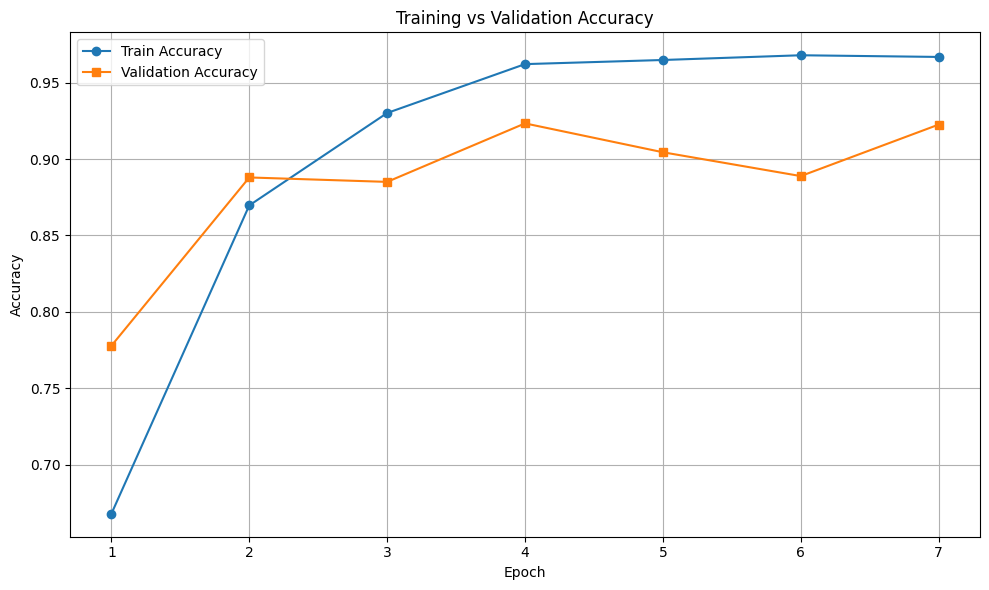

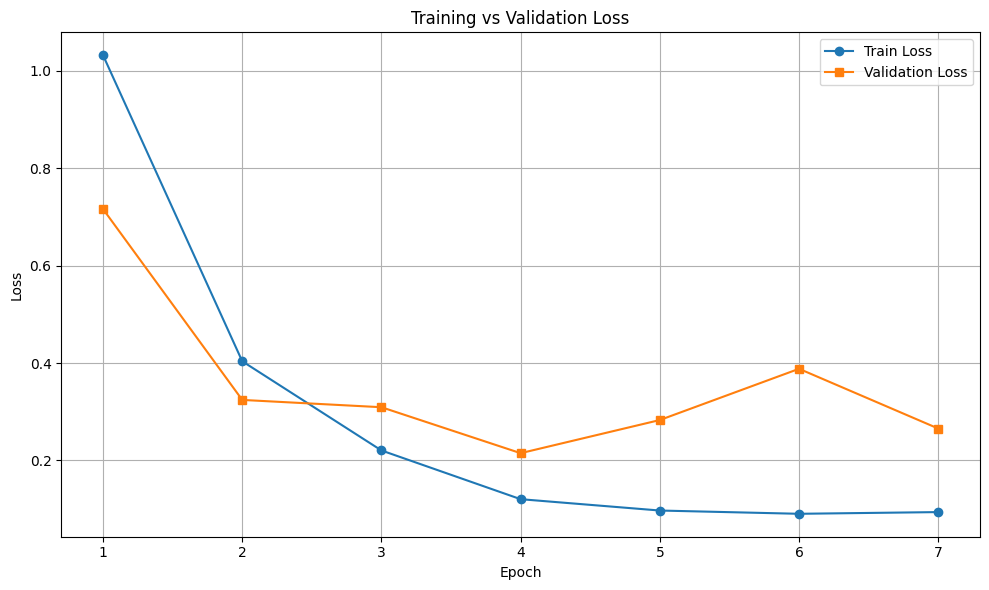

In [20]:
# Manually extracted data from your logs
train_loss = [1.0323, 0.4038, 0.2206, 0.1205, 0.0972, 0.0905, 0.0940]
val_loss   = [0.7164, 0.3244, 0.3094, 0.2150, 0.2831, 0.3883, 0.2656]

train_acc  = [0.6678, 0.8697, 0.9302, 0.9622, 0.9649, 0.9680, 0.9669]
val_acc    = [0.7778, 0.8880, 0.8851, 0.9234, 0.9045, 0.8889, 0.9226]

epochs = list(range(1, len(train_loss) + 1))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_plot.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot.png", dpi=300)
plt.show()
